In [1]:
import sys
from pathlib import Path
notebook_dir_listlike = !echo %cd%
project_path = str(Path(notebook_dir_listlike[0]).parent.absolute().parent.absolute())
sys.path.insert(0, project_path) if project_path not in sys.path else print('Project path is already in your PATH')

In [2]:
import pandas as pd
import seaborn as sns
from src.visualization.get_samples import get as get_samples

In [3]:
data = pd.read_csv('../data/processed/splited_atleast4.csv', encoding='utf8')

Была написана функция, которая считает долю токенов, имеющих специфически казахские символы (а также некоторые символы латиницы типа 'i'). С помощью нее можно хоть как-то оценить долю русских/казахских слов в тексте.

In [4]:
data.head()

,group,group_type,text_type,text,words_count,kz_words_count,percentage
0,asyl_arna,news,p,Қыздарды елең еткізетін тақырып,4,4,1.000000
1,asyl_arna,news,p,"Дегенмен, бүгінгі күні көп қыздың ең бір жанд...",18,13,0.722222
2,asyl_arna,news,p,Неге жанды жеріне тиеді,4,2,0.500000
3,asyl_arna,news,p,Онда тұрған не бар,4,1,0.250000
4,asyl_arna,news,p,Бұны айтпас бұрын алдымен бұл тақырыпты неге ...,27,15,0.555556


Ясно, что часто казахские слова записываются с помощью исключительно кириллической азбуки, такие случаи проходят мимо такого простого детектора. Также он ложно распознает многие англоязычные слова как казахские.

Так выглядит распределение доли казахских слов в текстах:

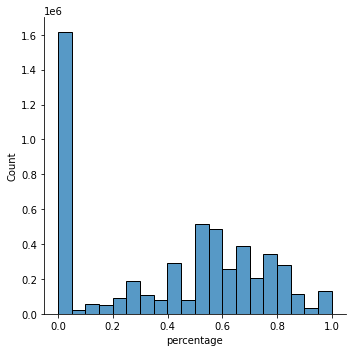

In [5]:
sns.displot(data, x='percentage', bins=20);

Отбросим пока чисто казахские и чисто русские тексты.

При этом важно понимать, что целевой класс, содержащий предложения, с существенной долей настоящих русских слов, но при этом не состоящий только из них, в основном лежит именно в категории с долей казахских слов, равной 0.00

Но для качественно его выявления надо вводить какую-то принципиально новую метрику оценки кол-ва казахских слов. В идеале эта метрика должны быть усточива к образованию казахских слов от русских добавлением суффиксов и приставок. Есть идея, как это можно сделать, это должно дать хороший прирост качества отделения русских слов от казахских.

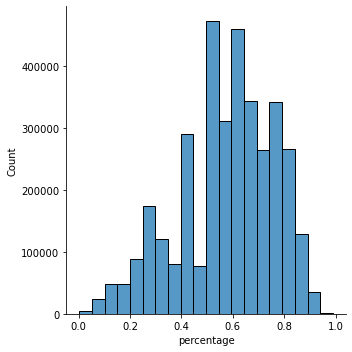

In [6]:
sns.displot(data[(data['percentage']!=0) & (data['percentage']!=1)], x='percentage', bins=20);

Видно, что некоторые конкретные проценты превалируют над другими. Особенно это заметно при большем количествые отрезков разбиения.

Связано это скорее всего с тем, что в масее своей тексты имеют небольую длину. Ниже приведено распределение кол-ва текстов (с <100 слов) от длины слов. При том, что из датасета уже выброшены все тексты короче 4 слов, некоторые конкертные значения доли казахских слов буду встречаться сильно чаще, т.к. подавляющее множество дробей имеют небольше множество значений знаменателя и числителя.

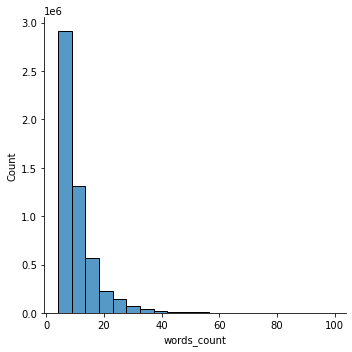

In [7]:
sns.displot(data[data['words_count']<100], x='words_count', bins=20);

In [8]:
# эта функция возвращает случайный список текстов из датасета 
samples = get_samples(df=data,             # датасет
                      del_only_kz=True,    # удалять ли из выборки чисто казахские тексты
                      del_only_ru=True,    # удалять ли из выборки чисто русские тексты
                      quantiles_count=100, # количество квантилей выборки
                      items_in_quantile=1) # количество текстов из каждого квантиля

Тексты я сохранил для дальнейшей разметки под Sentimental Analysis в отдельный файл. Его я переводил через переводчик яндекса, и потом отправлю на классификацию это уже обученной на русскоязычный sentimental analysis модели (такая есть в Keras).

Сейчас размечать вручную, мне кажется, пока не стоит, потому что все еще есть мусорные тексты, и главное, что с такой простой оценкой доли казахских слов теряется очень много "хороших" текстов именно на смешанном языке. Тем более если это будет самая такая отложенная выборка, которая сохранится до конца работы над проектом.

Хочу сейчас привести проект в нормальный вид, с которым удобно работать. Затем надо будет почистить тексты и написать более качественный алгортим оценки доли казахских слов. На этих данных уже можно будет пробовать строить языковую модель, которую можно сравнивать в решении той же задачи анализа тональности текста с готовыми русскоязычными моделями, примененными к переведенным текстам того же датасета.